# Setup

In [ ]:
# load libraries
import os
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# control the figure size
plt.rcParams["figure.figsize"] = (20,3)


In [ ]:
# load demand data
demand_data = pd.read_csv(
    'https://raw.githubusercontent.com/nosadchiy/public/main/demand.csv',
    dtype={"Month": str, "Date": int, "Demand": int})

# load intake price data
intake_price_data =  pd.read_csv(
    'https://raw.githubusercontent.com/nosadchiy/public/main/intake_price.csv',
    dtype={"Intake": int, "Price": float})

In [ ]:
# inspect demand data
demand_data.head()

,Month,Date,Demand
0,December,1,94
1,December,2,304
2,December,3,70
3,December,4,222
4,December,5,123


In [ ]:
# inspect intake price data
intake_price_data.head()

,Intake,Price
0,20,1.0
1,24,1.0
2,31,1.0
3,34,1.0
4,37,1.0


# Decision Variables

In [ ]:
# decision variables
calng_price = 7.50 # set by CaLNG

peak_intake_from_pipeline = 303 #181

# Utility (Actual Usage)

In [ ]:
def determine_actual_usage(demand_data, calng_price, peak_intake_from_pipeline, total_lng_intake):
    '''
    this function determines the actual usage given CaLNG's price and peak intake from pipeline

    inputs:
    - calng_price: price set by CaLNG
    - peak_intake_from_pipeline: maximum intake from pipeline, after which consume LNG
    - demand_data: observed demand data (Month, Data, Demand in MMcF)
    - total_lng_intake: maximum amount ogf LNG to be used over the season

    outputs:
    - usage_data: usage data given observed demand, CaLNG price, and peak intake from pipeline
    '''
    usage_data = demand_data.copy()

    # set price index
    usage_data.reset_index(inplace=True, drop=False)
    usage_data = usage_data.rename(columns={'index': 'price_index'})

    usage_data['pipeline_price'] = usage_data.apply(lambda row: math.exp(max(0, (row['Demand'] - 144)/60)), axis=1)
    usage_data['cost_from_pipeline_only'] = usage_data['Demand'] * usage_data['pipeline_price']
    usage_data['demand_for_lng'] = usage_data.apply(lambda row: max(row['Demand'] - peak_intake_from_pipeline, 0), axis=1)
    usage_data['purchase_from_calng'] = 0

    accumulated_lng_usage = 0

    for index, row in usage_data.iterrows():
        purchase =  min(row['demand_for_lng'], total_lng_intake - accumulated_lng_usage)
        usage_data.loc[index, 'purchase_from_calng'] = purchase
        accumulated_lng_usage = accumulated_lng_usage + purchase


    usage_data['pipeline_intake'] = usage_data['Demand']-usage_data['purchase_from_calng']
    usage_data['pipeline_intake_price'] = usage_data.apply(lambda row: math.exp(max(0, (row['pipeline_intake'] - 144)/60)), axis=1)
    usage_data['cost_from_both'] = usage_data['pipeline_intake'] * usage_data['pipeline_intake_price'] + usage_data['purchase_from_calng'] * calng_price
    usage_data['savings'] = usage_data['cost_from_pipeline_only'] - usage_data['cost_from_both']

    return usage_data


In [ ]:
# get usage data
usage_data = determine_actual_usage(demand_data, calng_price, peak_intake_from_pipeline, 1288) # 1288 can change to 0
# maximinze height over peak peak_intake_from_pipeline,
# inspect usage_data (round to 2 decimal places)
np.round(usage_data,2)

,price_index,Month,Date,Demand,pipeline_price,cost_from_pipeline_only,demand_for_lng,purchase_from_calng,pipeline_intake,pipeline_intake_price,cost_from_both,savings
0,0,December,1,94,1.00,94.00,0,0,94,1.00,94.00,0.00
1,1,December,2,304,14.39,4375.14,1,1,303,14.15,4296.17,78.97
2,2,December,3,70,1.00,70.00,0,0,70,1.00,70.00,0.00
3,3,December,4,222,3.67,814.58,0,0,222,3.67,814.58,0.00
4,4,December,5,123,1.00,123.00,0,0,123,1.00,123.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...
86,86,February,25,52,1.00,52.00,0,0,52,1.00,52.00,0.00
87,87,February,26,39,1.00,39.00,0,0,39,1.00,39.00,0.00
88,88,February,27,109,1.00,109.00,0,0,109,1.00,109.00,0.00
89,89,February,28,250,5.85,1462.83,0,0,250,5.85,1462.83,0.00


In [ ]:
def calculate_cost_statistics(usage_data, calng_price, peak_intake_from_pipeline, total_lng_purchase, return_data=False):
    cost_data = usage_data.copy()
    cost_data['pipeline_intake_cost'] = cost_data['pipeline_intake'] * cost_data['pipeline_intake_price']
    cost_data['calng_intake_cost'] = cost_data['purchase_from_calng'] * calng_price

    total_pipeline_intake = sum(cost_data['pipeline_intake'])
    total_calng_intake = sum(cost_data['purchase_from_calng'])

    total_pipeline_intake_cost = sum(cost_data['pipeline_intake_cost']) * 1000
    total_calng_intake_cost = total_lng_purchase*calng_price * 1000
    total_utility_cost = total_pipeline_intake_cost + total_calng_intake_cost
    total_savings = sum(cost_data['savings']) * 1000

    average_demand = np.mean(cost_data['Demand'])
    average_price = math.exp(max(0, (average_demand - 144)/60))

    total_average_draw_daily = sum(cost_data['Demand']) * average_price * 1000

    if not return_data:
        print(f"CaLNG price: ${calng_price:<04}")

        print("---")
        print(f"Peak intake from pipeline: {peak_intake_from_pipeline:,.0f} MMcf")
        print(f"Total peak months intake from pipeline: {total_pipeline_intake:,.0f} MMcf")
        print(f"Total intake from CaLNG: {total_calng_intake:,.0f} MMcf")

        print("---")
        print(f"Total amount paid to pipeline: ${total_pipeline_intake_cost:,.0f}")
        print(f"Total amount paid to CaLNG: ${total_calng_intake_cost:,.0f}")
        print(f"Total cost for utility: ${total_utility_cost:,.0f}")
        print(f"Savings from using CaLNG: ${total_savings:,.0f}")

        print("---")
        print(f"Total cost if average draw daily: ${total_average_draw_daily:,.0f}")

    else:
        cost_stat_dict = {
            "peak_intake_from_pipeline": peak_intake_from_pipeline,
            "total_lng_purchase": total_lng_purchase,
            "total_pipeline_intake": total_pipeline_intake,
            "total_calng_intake": total_calng_intake,
            "total_pipeline_intake_cost": total_pipeline_intake_cost,
            "total_calng_intake_cost": total_calng_intake_cost,
            "total_utility_cost": total_utility_cost,
            "total_savings": total_savings,
            "total_average_draw_daily": total_average_draw_daily
        }

        return cost_stat_dict

In [ ]:
calculate_cost_statistics(usage_data, calng_price, peak_intake_from_pipeline, 1288)

CaLNG price: $7.50
---
Peak intake from pipeline: 303 MMcf
Total peak months intake from pipeline: 13,715 MMcf
Total intake from CaLNG: 1 MMcf
---
Total amount paid to pipeline: $40,118,092
Total amount paid to CaLNG: $9,660,000
Total cost for utility: $49,778,092
Savings from using CaLNG: $78,969
---
Total cost if average draw daily: $15,342,871


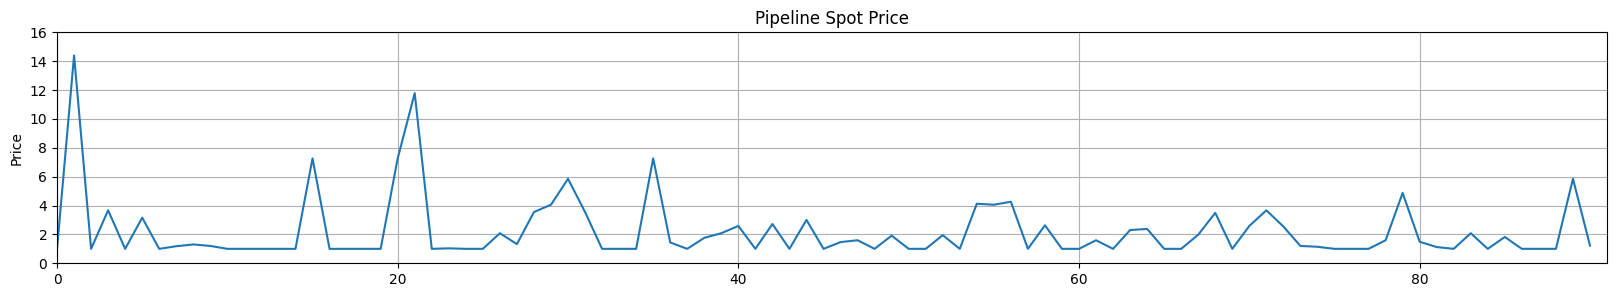

In [ ]:
sns.lineplot(data=usage_data, x='price_index', y='pipeline_price')
plt.title('Pipeline Spot Price')
plt.axis([0, 91, 0, 16])
plt.grid()
plt.xlabel("")
plt.ylabel("Price")
plt.show()

# Demand

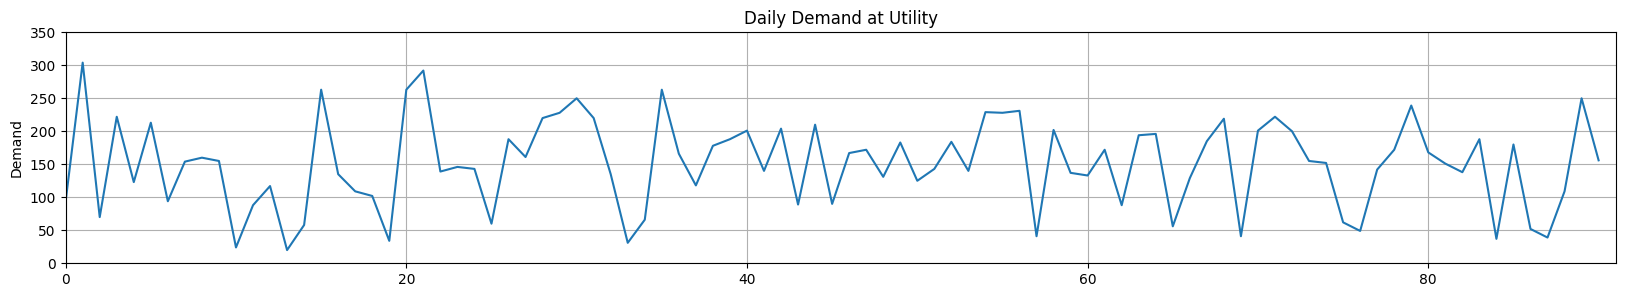

In [ ]:
sns.lineplot(data=usage_data, x='price_index', y='Demand')
plt.title('Daily Demand at Utility')
plt.axis([0, 91, 0, 350])
plt.grid()
plt.xlabel("")
plt.ylabel("Demand")
plt.show()

# Intake from Pipeline

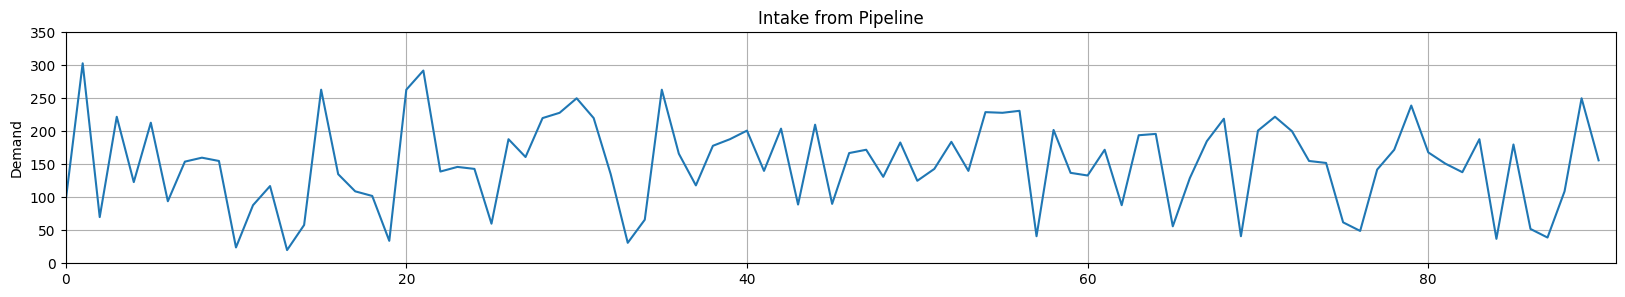

In [ ]:
sns.lineplot(data=usage_data, x='price_index', y='pipeline_intake')
plt.title('Intake from Pipeline')
plt.axis([0, 91, 0, 350])
plt.grid()
plt.xlabel("")
plt.ylabel("Demand")
plt.show()

# CaLNG Purchase

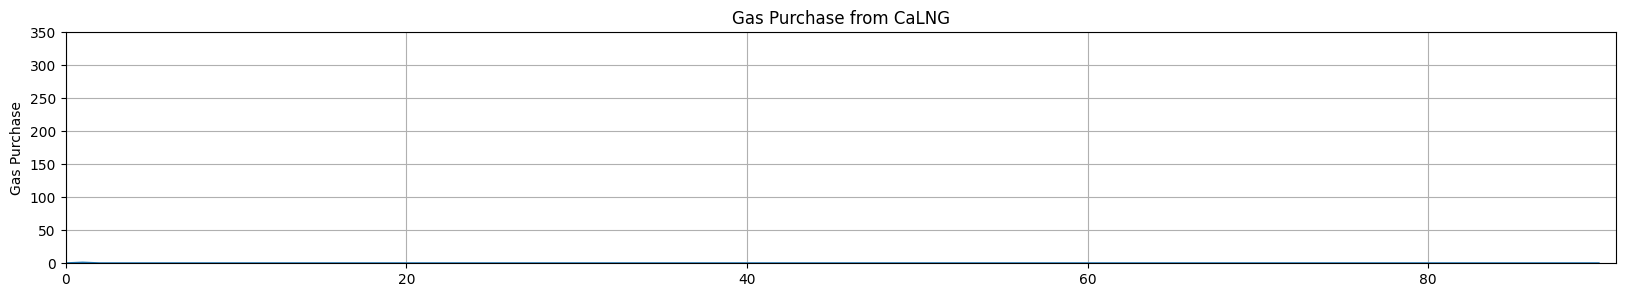

In [ ]:
sns.lineplot(data=usage_data, x='price_index', y='purchase_from_calng')
plt.title('Gas Purchase from CaLNG')
plt.axis([0, 91, 0, 350])
plt.grid()
plt.xlabel("")
plt.ylabel("Gas Purchase")
plt.show()

# Intake vs. Spot Price

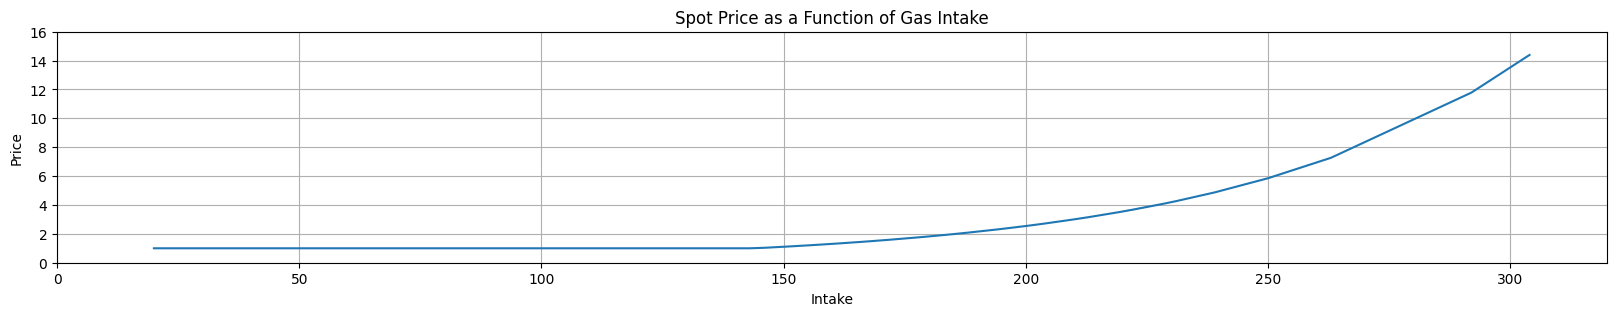

In [ ]:
sns.lineplot(data=intake_price_data, x='Intake', y='Price')
plt.title('Spot Price as a Function of Gas Intake')
plt.axis([0, 320, 0, 16])
plt.grid()
plt.show()

# Option

In [ ]:
# demand randomization parameters
mean_daily_demand = 144
std_dev_daily_demand = 59

#decision variables
total_lng = 1200
peak_intake_from_pipeline = 180

In [ ]:
# simulate demand data
sim_demand_data = demand_data.copy()

# generate sample
demand_sample = np.random.normal(mean_daily_demand, std_dev_daily_demand, len(sim_demand_data))
demand_sample = np.round(np.where(demand_sample < 0, 0, demand_sample),0)

sim_demand_data['Demand'] = demand_sample
sim_usage_data = determine_actual_usage(sim_demand_data, calng_price, peak_intake_from_pipeline, total_lng)

calculate_cost_statistics(sim_usage_data, calng_price, peak_intake_from_pipeline, total_lng)

CaLNG price: $7.50
---
Peak intake from pipeline: 180 MMcf
Total peak months intake from pipeline: 13,031 MMcf
Total intake from CaLNG: 979 MMcf
---
Total amount paid to pipeline: $19,072,843
Total amount paid to CaLNG: $9,000,000
Total cost for utility: $28,072,843
Savings from using CaLNG: $7,319,580
---
Total cost if average draw daily: $16,538,739


# Option Optimization
In progress

In [ ]:
# number of simulation draws per scenario
num_draws = 5000

# decision variables
total_lng_range = range(700, 1300, 50)
peak_intake_from_pipeline_range= range(170,200,5)

cost_stat_list = []

for total in total_lng_range:
    for peak in peak_intake_from_pipeline_range:
        sims = []
        for n in range(num_draws):
            # simulate demand data
            sim_demand_data = demand_data.copy()

            # generate sample
            demand_sample = np.round(np.random.normal(mean_daily_demand, std_dev_daily_demand, len(sim_demand_data)))
            demand_sample = np.where(demand_sample < 0, 0, demand_sample)

            sim_demand_data['Demand'] = demand_sample

            # get simulated usage data
            sim_usage_data = determine_actual_usage(sim_demand_data, calng_price, peak, total)
            cost_stat_dict = calculate_cost_statistics(sim_usage_data, calng_price, peak, total, return_data=True)


            sims.append(cost_stat_dict)


        cost_stat_list.append(np.mean(pd.DataFrame(sims), axis=0))

df = pd.DataFrame(cost_stat_list)



In [ ]:

df = pd.DataFrame(cost_stat_list)

opt_row = df.loc[df['total_utility_cost'].idxmin()]

optimum_total_lng = opt_row['total_lng_purchase']
optimum_peak_intake = opt_row['peak_intake_from_pipeline']

print(f"Optimum Total LNG Purchase: {optimum_total_lng}")
print(f"Optimum Peak Intake from Pipeline: {optimum_peak_intake}")



Optimum Total LNG Purchase: 900.0
Optimum Peak Intake from Pipeline: 180.0


In [ ]:

df['average_cost_per_unit'] = df['total_utility_cost'] / df['total_lng_purchase']

optimum_average_cost_per_unit = df.loc[(df['peak_intake_from_pipeline'] == optimum_peak_intake) &
                                       (df['total_lng_purchase'] == optimum_total_lng),
                                       'average_cost_per_unit'].iloc[0]

print(f"Average Cost per Unit at Optimum Conditions: {optimum_average_cost_per_unit}")

Average Cost per Unit at Optimum Conditions: 27930.519228180892


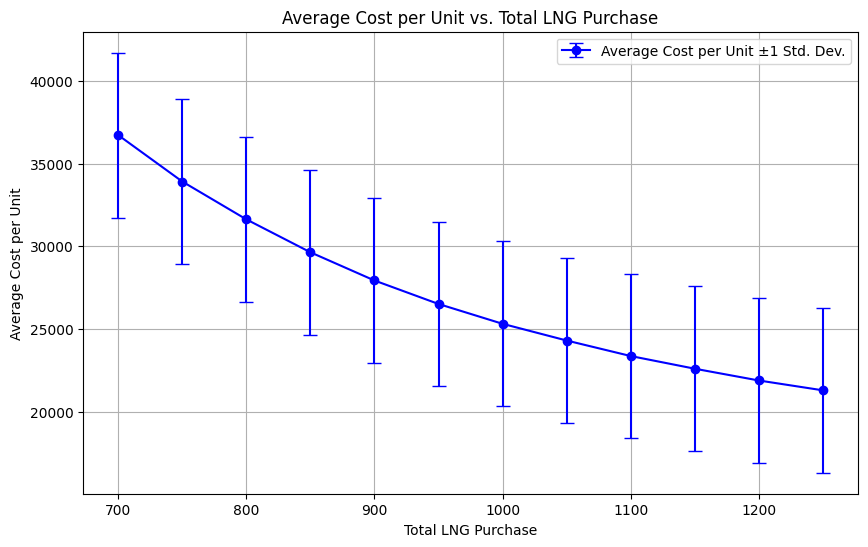

In [ ]:

#plot 1
optimum_peak_intake = 180.0

df_peak_optimum = df[df['peak_intake_from_pipeline'] == optimum_peak_intake]


plt.figure(figsize=(10, 6))

plt.errorbar(df_peak_optimum['total_lng_purchase'], df_peak_optimum['average_cost_per_unit'],

             yerr=df_peak_optimum['average_cost_per_unit'].std(), fmt='-o', ecolor='blue', capsize=5, color='blue',

             label='Average Cost per Unit ±1 Std. Dev.')

plt.title('Average Cost per Unit vs. Total LNG Purchase')

plt.xlabel('Total LNG Purchase')

plt.ylabel('Average Cost per Unit')

plt.legend()

plt.grid(True)

plt.show()

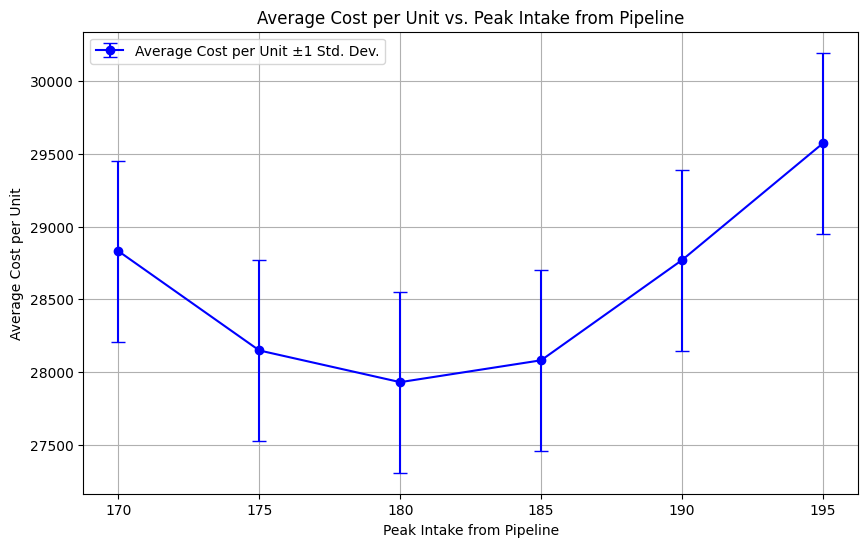

In [ ]:
#plot 2
optimum_total_lng = 900

df_lng_optimum = df[df['total_lng_purchase'] == optimum_total_lng]


plt.figure(figsize=(10, 6))

plt.errorbar(df_lng_optimum['peak_intake_from_pipeline'], df_lng_optimum['average_cost_per_unit'],

             yerr=df_lng_optimum['average_cost_per_unit'].std(), fmt='-o', ecolor='blue', capsize=5, color='blue',

             label='Average Cost per Unit ±1 Std. Dev.')

plt.title('Average Cost per Unit vs. Peak Intake from Pipeline')

plt.xlabel('Peak Intake from Pipeline')

plt.ylabel('Average Cost per Unit')

plt.legend()

plt.grid(True)

plt.show()